In [1]:
import pyfar as pf
import sofar as sf
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import scipy.signal as sps

In [2]:
sd.default.device = 22

### Deconvolve and crop ema recordings

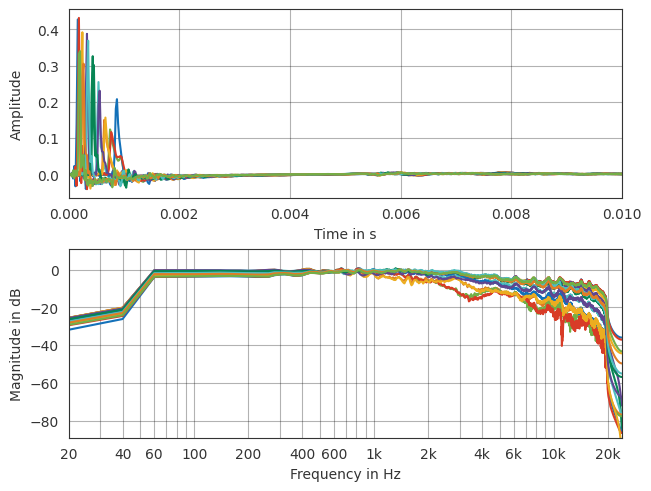

In [27]:
# load signals and excitation signal
sweep = pf.dsp.normalize(
    pf.io.read_audio(r"Measurements RAR/25_01_21_ref_rar_50Hz_20kHz.wav"), 
    channel_handling='max')
system = pf.dsp.normalize(
    pf.io.read_audio(r"Measurements RAR/25_01_21_ema_16_rar_50Hz_20kHz.wav"))


# deconvolve and shift
ir_ema = pf.dsp.deconvolve(system, sweep, frequency_range=[50, 19500])
ir_shifted = pf.dsp.fractional_time_shift(ir_ema, 20, mode='cyclic')

# Fir hp filter
numtaps, beta = sps.kaiserord(65, 24/(0.5*ir_ema.sampling_rate))
b = sps.firwin(numtaps, 54, pass_zero=False, fs=ir_ema.sampling_rate, window=('kaiser', beta))
b_min = sps.minimum_phase(b, 'hilbert')
FIR = pf.FilterFIR(b_min, ir_ema.sampling_rate)
ir_filtered = FIR.process(ir_shifted)

# window IR
ir_filtered = pf.dsp.time_window(ir_filtered, [0, 0.0001, .049, .05], crop='window', unit='s', shape='right')



# pf.plot.time_freq(ir_ema[2], dB_time=True)
# ax = pf.plot.time_freq(ir_shifted[2], dB_time=True, label='shifted IR')
ax = pf.plot.time_freq(ir_filtered, dB_time=False, label='filtered and windowed IR')
# ax[1].legend()
ax[0].set_xlim(0, 0.01)
plt.show()

In [7]:
pf.io.write_audio(ir_filtered, "Impulse Responses/EMA_RAR/ir_ema_rar.wav")

In [161]:
0.0053 * 48000

254.4

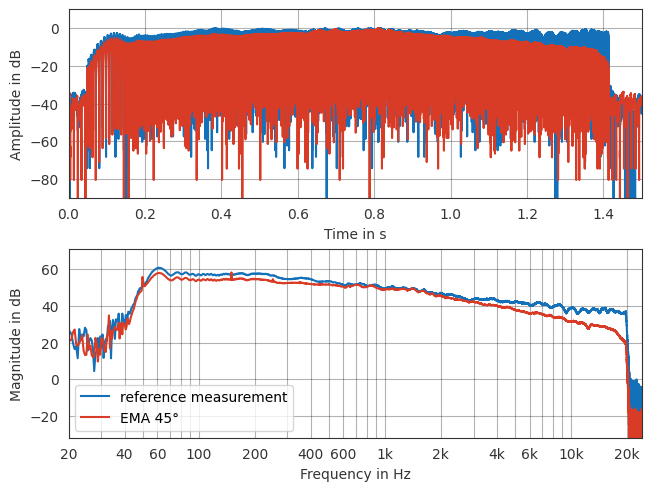

In [141]:
ax = pf.plot.time_freq(sweep, dB_time=True, label='reference measurement')
ax = pf.plot.time_freq(system[2], dB_time=True, label='EMA 45°')
ax[1].legend()
ax[0].set_xlim(0, 1.5)
plt.show()

In [5]:
pf.io.write_audio(ir_ema, r'Impulse Responses/ir_ema_window_room.wav', overwrite=False)

FileExistsError: File already exists,use overwrite option to disable error.

### Deconvolve BRIR

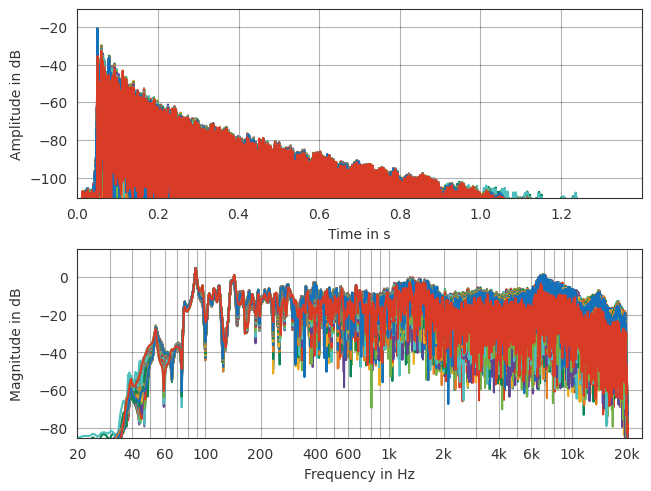

In [111]:
# load signals and angles
sweep = pf.dsp.normalize(
    pf.io.read_audio(r"BRIR_Window_Room/sweep_50Hz_20kHz.wav"),
    channel_handling='max')
system = pf.dsp.normalize(
    pf.io.read_audio(r"BRIR_Window_Room/system_response_dummyhead_1.wav"),
    channel_handling='max')

# load angles (rotation of the dummy head)
angles = np.load(r'BRIR_Window_Room/angle_1.npy')

reshaped = system.time.reshape(len(angles), 2, system.n_samples)
room_response = pf.Signal(reshaped, system.sampling_rate)

# deconvolve
brir = pf.dsp.deconvolve(room_response, sweep, freq_range=[50, 19500])
# filter
brir = pf.dsp.filter.butterworth(brir, 8, 50, 'highpass')
# truncate (sparta plugins like multiples of 128)
brir = pf.dsp.time_window(brir, [0, 1000, 520*128, 525*128-1], crop='window', 
                          unit='samples', shape='symmetric')


pf.plot.time_freq(brir, dB_time=True)
plt.show()

In [71]:
anechoic = pf.io.read_audio(r'c:\Users\HP\Downloads\Mov3_Trio_Violin1_Haydn_StringQuartet_op76_n1.wav')[13]
anechoic = pf.dsp.resample(anechoic, 48000)

id = np.argwhere(angles==-90)

audio = pf.dsp.convolve(anechoic, brir[id])

sd.play(audio.time.T.squeeze(), 48000)

#### save as SOFA-File

In [ ]:
sofa = sf.Sofa('SimpleFreeFieldHRIR')
sofa.Data_IR = brir.time
sofa.Data_SamplingRate = brir.sampling_rate

sofa.SourcePosition_Units = 'degree, degree, metre'  # alternatively 'degrees'
sofa.SourcePosition_Type = 'spherical'
sofa.SourcePosition = np.array([-angles, np.zeros_like(angles), 1.45*np.ones_like(angles)]).T

sofa.verify()

# sf.write_sofa('BRIR90.sofa', sofa)

(37, 2, 67200)


In [74]:
# load sofa file and plot source positions
ir, src, rec = pf.io.read_sofa('BRIR90.sofa')

idx = np.argwhere(np.rad2deg(src.azimuth) == 0)

print(np.rad2deg(src.azimuth))

audio = pf.dsp.convolve(anechoic, ir[idx.squeeze()])

sd.play(audio.time.T.squeeze(), 48000)

[ 90.  85.  80.  75.  70.  65.  60.  55.  50.  45.  40.  35.  30.  25.
  20.  15.  10.   5.   0. 355. 350. 345. 340. 335. 330. 325. 320. 315.
 310. 305. 300. 295. 290. 285. 280. 275. 270.]


SOFA file contained custom entries
----------------------------------
GLOBAL_Author, GLOBAL_ListenerDescription, GLOBAL_ReceiverDescription, GLOBAL_SourceDescription, GLOBAL_RoomDescription


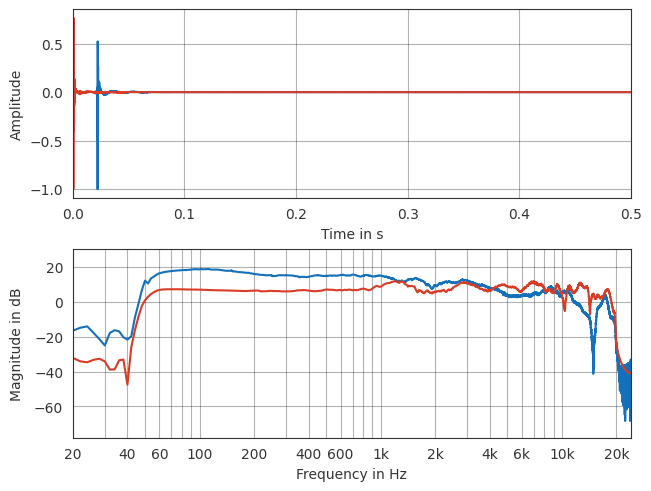

In [23]:
import scipy as sc

irs, _, _= pf.io.read_sofa(r'HMSII.sofa')


audio = sc.io.loadmat('Impulse Responses/EMA_RAR/Decoded_BRIR/brir_ema_0_ls.mat')
audio = audio['out_lr']

sig = pf.Signal(audio.T, 48000)

pf.plot.time_freq(pf.dsp.normalize(sig[1]))
pf.plot.time_freq(pf.dsp.normalize(ir_filtered[1]))
plt.show()